In [2]:
import numpy as np
import scipy.special as sspec
import scipy.stats as ss
import scipy.sparse as sspar
import multiprocessing as mp
import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
def drift(x):
    return np.arctan(x)

def diff(x):
    return np.sqrt(1 + x**2)

In [4]:
def f(x,s,h):
    return np.exp(1j*s*h*drift(x) - h*np.abs(s)*diff(x)) 

In [126]:
# set up nonequispaced grids of s and u values
# uvec will have length sres+1, which is to implement nonequispaced quadrature later
smax = 10
sres = 2500
uvec = smax*np.exp(-np.linspace(np.log(smax),0,sres//2)**3)
uvec = np.hstack([-np.flip(uvec,axis=0), 0, uvec])
svec = np.copy(uvec)
ures = len(uvec)
sres = len(svec)

In [127]:
# set the value of h
thish = 0.25

# set the initial condition parameters
mymean = 0.5
mysd = 0.5

# set the initial pdf
def initp(x):
    return ss.norm.pdf(x,loc=mymean,scale=mysd)

# set the initial charfun
def initpcf(s):
    return np.exp(1j*mymean*s - 0.5*(mysd*s)**2)

In [128]:
# set up x grid for integration
Nx = 128
L = 12.8
dx = L/Nx
xvec = np.arange(-L/2,L/2,dx)

In [129]:
# initialize kernel matrix
# kernelmat = np.zeros((sres,sres),dtype='D')

In [130]:
def computeonerow(i):
    
    outrow = np.zeros(ures,dtype='D')
    s = svec[i]
    
    # handle special Dirac delta case
    if i==(sres//2):
        return sspar.csr_matrix(outrow[:-1]), sspar.csr_matrix(outrow[1:])
    
    # handle "boundary layer" near Dirac delta
    # if np.abs(svec[i])<1.0:
    #     outrow[sres//2] = 1.0/ds
    #     outrow[(sres//2 + 1)] = s*0.5/(ds*ds)
    #     outrow[(sres//2 - 1)] = -s*0.5/(ds*ds)
    #     return outrow
    
    # compute shifted coordinate
    k = s - uvec
        
    # compute integral for all values of u
    for j in range(Nx):
        
        # compute quadrature points
        x1 = xvec[j]
        x2 = x1 + dx
        
        # product quadrature rule
        m0 = np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), 1j*k, 
                       out=dx*np.ones_like(k,dtype='D'), where=k!=0)
        m1 = np.divide((x2*np.exp(1j*k*x2) - x1*np.exp(1j*k*x1)), 1j*k, 
                       out=0.5*(x2**2 - x1**2)*np.ones_like(k,dtype='D'), where=k!=0)
        m1 += np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), k**2, 
                        out=np.zeros_like(k,dtype='D'), where=k!=0)
        
        # compute quadrature weights
        w1 = -(m1 - x2*m0)/dx
        w2 = (m1 - x1*m0)/dx
        
        # compute integral over [x1, x2]
        outrow += w1*f(x1,s,thish) + w2*f(x2,s,thish)
    
    # add asymptotic corrections
    outrow += 2.0*np.real((1j*np.exp((1j*(thish*np.pi*s + L*k + 1j*thish*L*np.abs(s)))/2.))/(k + 1j*thish*np.abs(s)))
    # outrow += (-1j*np.exp((-1j*(thish*np.pi*s + L*k - 1j*thish*L*np.abs(s)))/2.))/(k - 1j*thish*np.abs(s))
    outrow /= (2.0*np.pi)
    
    outrow[np.abs(outrow)<=1.0e-8] = 0
    
    return sspar.csr_matrix(outrow[:-1]),sspar.csr_matrix(outrow[1:])


In [131]:
curtime = time.time()
pool = mp.Pool(processes=24)
kernelmat = pool.map(computeonerow, range(sres))
leftkernelmat, rightkernelmat = map(sspar.vstack, list(zip(*kernelmat)))

# templist = [list(x) for x in zip(*kernelmat)]
# leftkernelmat = sspar.vstack(templist[0])
# rightkernelmat = sspar.vstack(templist[1])

print(leftkernelmat.shape)
print(rightkernelmat.shape)
timetaken = time.time() - curtime
print(timetaken)
pool.close()

# bigeig, _ = ssla.eigs(kernelmat,k=1,which='LM')
# print(np.abs(bigeig[0]*ds))
# bigeig, _ = ssla.eigs(kernelmat-kernelmat[sres//2,],k=1,which='LM')
# print(np.abs(bigeig[0]*ds))


(2501, 2500)
(2501, 2500)
57.679203033447266


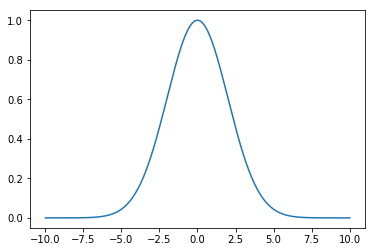

In [132]:
plt.plot(svec, np.abs(initpcf(svec)))

In [133]:
# plt.plot(svec[1:],np.abs(np.diag(np.dot(kernelmat[1:,1:],np.diag(du)))))

In [134]:
# testmat = np.random.random((3,3))
# print(testmat)

# leave out the first column
# print(testmat[:,1:])

# leave out the last column
# print(testmat[:,:-1])

# cf = initpcf(svec)
# print(len(cf))
# print(sres)
# cf[(sres-1)//2]

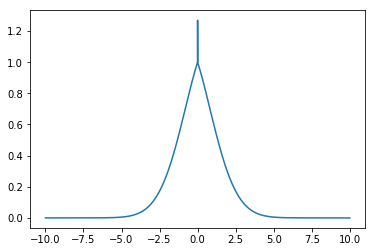

In [135]:
du = np.diff(uvec)
cf = initpcf(svec)

numsteps = 1
for i in range(numsteps):
    left = cf[0:(sres-1)]*du
    right = cf[1:sres]*du
    # cf = 0.5*(leftkernelmat[:,:-1].dot(left) + rightkernelmat[:,1:].dot(right))
    cf = 0.5*(leftkernelmat.dot(left) + rightkernelmat.dot(right))
    cf[(sres-1)//2] = 1.0

plt.plot(svec, np.abs(cf))

In [136]:
cf[sres//2 + 1]

(1.2611216653846662+3.8291935991157325e-05j)

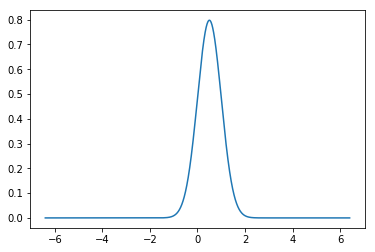

In [137]:
# set up x grid for plotting
Nxplot = 16384
Lplot = 12.8
dxplot = Lplot/Nxplot
xplot = np.arange(-Lplot/2,Lplot/2,dxplot)

# initial PDF
plt.plot(xplot, initp(xplot))

In [138]:
# Fourier matrix
fouriermat = np.zeros((Nxplot,sres),dtype='D')
for i in range(Nxplot):
    fouriermat[i,] = np.exp(-1j*uvec*xplot[i])/(2.0*np.pi)


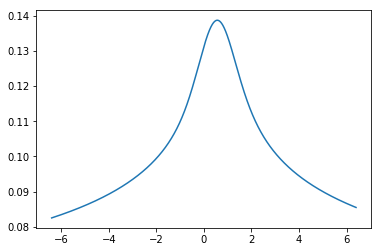

In [139]:
# PDF at next time step
plt.plot(xplot, np.real(dxplot*np.dot(fouriermat,cf)))

In [140]:
np.save(file='kernelmatNEh0.25s2500',arr=kernelmat)